## ExMAS
> Equilibrium matching - expieriments for the paper

---
# Toy network

* 10 requests
* 23 possible rides

#### Content:

* incidence matrix
* costs as a column sums
* costs for individuals
* solution: system optimal for users
* solution: system optimal for operator

In [ ]:
import os
import math
import seaborn as sns
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
cwd = os.getcwd()
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display
pd.options.display.max_columns = None

In [3]:
os.chdir(os.path.join(cwd,'../../..'))
import ExMAS.main
import ExMAS.utils
from ExMAS.utils import inData as inData
from ExMAS.main import matching, evaluate_shareability
from ExMAS.extras import games, pricings, prunings

In [4]:
params = ExMAS.utils.get_config('ExMAS/spinoffs/game/game_toy.json') # load the default 
params.t0 = pd.to_datetime(params.t0)
params.matching_obj = 'u_pax'
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph
#inData.requests = ExMAS.utils.load_requests('ExMAS/spinoffs/game/toy.csv')

In [5]:
params.nP = 50
params.shared_discount = 0.3

In [6]:
inData = ExMAS.utils.generate_demand(inData, params)

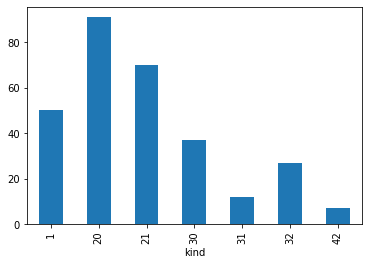

In [7]:
inData = ExMAS.main(inData, params, plot = False)
KPIs = inData.sblts.res.to_frame('u_pax')
inData.sblts.rides.groupby('kind').size().plot(kind='bar')

In [8]:
from ExMAS.main import init_log
params.logger_level = 'WARNING'
inData.logger = init_log(params)

In [44]:
rm = inData.sblts.rides_multi_index
rm.loc[0,:][['traveller', price_column]]

NameError: name 'price_column' is not defined

In [93]:
price_column = 'uniform_split'
r = 320
costs_of_G2_with_i = rm.loc[pd.IndexSlice[r, [7,12]], :][['traveller', price_column]] # costs for travellers in G2 with i  
costs_of_G2  = rm.loc[pd.IndexSlice[50, :], :][['traveller', price_column]] # costs for travellers in G2 with i      
costs_of_G2

traveller  uniform_split
50 7           7        1.98905
   12         12        1.98905

In [122]:
costs_of_G2_with_i

traveller  uniform_split
320 7           7       3.021725
    12         12       3.021725

In [129]:
lsuffix = '_G2'
rsuffix = '_G2_with_i'
#costs_of_G2.join(costs_of_G2_with_i[price_column],  on = 'traveller', lsuffix=lsuffix, rsuffix=rsuffix) # merge for comparison 
pd.merge(costs_of_G2,costs_of_G2_with_i, on = ['traveller'])

,traveller,uniform_split_x,uniform_split_y
0,7,1.98905,3.021725
1,12,1.98905,3.021725


In [77]:
rm.loc[pd.IndexSlice[230, {35, 7}], :]

ride  traveller  shared  degree  treq ride_time  dist  ttrav  \
230 35   230         35    True       3   106       506  1809    226   
    7    230          7    True       3    12       506  1945    243   

        ttrav_sh  delay distance cost_veh  cost_user  cost_single  \
230 35       257  -95.0     4048   2.3023    1.39825       0.7910   
    7        395  110.0     4048   2.3023    1.96000       0.8505   

        uniform_split  price_single  surplus  pruned_user  pruned  
230 35         2.5431       1.81930 -0.72380        False   False  
    7          2.5431       1.95615 -0.58695        False   False

In [136]:
def algo_5(inData, price_column = 'uniform_split', _print = False):
    rm = inData.sblts.rides_multi_index
    rides = inData.sblts.rides
    lsuffix = '_x'
    rsuffix = '_y'
    unstables = list()
    indexes_set = rides.indexes_set
    
    def are_unstable(G1, G2):
        for i in indexes_set[G1]: # examine each i in G1
            G2s_with_i = G2s.union({i})  # move i to G2
            for r in rides[rides.indexes_set==G2s_with_i].index:  # loop over rides where i joining G2
                if rm.loc[r,i].cost_user < rm.loc[G1,i].cost_user: # condition 1 (i want to join G1)
                    costs_of_G2_with_i = rm.loc[pd.IndexSlice[r, G2s], :][['traveller', price_column]] # costs for travellers in G2 with i 
                    compare = pd.merge(costs_of_G2,costs_of_G2_with_i, on = ['traveller'])
                    #df = costs_of_G2.join(costs_of_G2_with_i[price_column], lsuffix=lsuffix, rsuffix=rsuffix) # merge for comparison 
                    compare['surplus'] = compare[price_column + lsuffix] - compare[price_column + rsuffix]
                    if compare.surplus.min() >= 0:
                        if _print:
                            print('Group1:', G1, G1s)
                            print('Group2:', G2, G2s)
                            print('Moving traveller:',i)
                            print('Group2 with i:', r, G2s_with_i)
                            print('Costs for i in G1:', rm.loc[G1,i].cost_user)
                            print('Costs for i in G2:', rm.loc[r,i].cost_user)
                            print('Costs for G2 without i \n ', costs_of_G2[price_column])
                            print('Costs for G2 with i \n ', costs_of_G2_with_i[price_column])
                        return True
        return False

    for G2 in rides.index: # loop over ride
        G2s = indexes_set[G2] # travellers in G2
        costs_of_G2 = rm.loc[G2, :][['traveller', price_column]] # costs of group G2 before joining
        for G1 in rides.index: # pairs   
            G1s = indexes_set[G1] # travellers in G1
            if indexes_set[G1].isdisjoint(indexes_set[G2]): # if rides are disjoint
                if are_unstable(G1,G2):
                    unstables.append([G1,G2])
    inData.sblts.mutually_exclusives = unstables
            
    
    return inData
algo_5(inData)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,lambda_r,PassHourTrav_ns,row,selected,treqs,deps,delays,ttravs,indexes_set,subgroups,supergroups,rankings,mean_ranking,rel_rankings,mean_rel_ranking,PoAs,mean_PoA,total_PoA,squared_PoA,probs,min_prob,logsum_prob,costs_user,costs_veh,pruned,platform,hermetic
0,[0],2.89200,186,1,[2.8920000000000003],"[0, 186]",[0],[0],1,0,0.300000,186,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,[0],[0],[0],[186],{0},[0],"[0, 107, 182, 312]",[3.0],3.00,[0.75],0.750000,[0.3999999999999999],0.400,0.4,0.1600,[0.008993104981045778],0.008993,-4.711297,0.65100,0.84630,True,1,True
1,[1],0.74550,48,1,[0.7455],"[0, 48]",[1],[1],1,1,0.300000,48,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,[0],[0],[0],[48],{1},[1],[1],[1.0],1.00,[1.0],1.000000,[0.0],0.000,0.0,0.0000,[1.0],1.000000,0.000000,0.16800,0.21840,True,1,True
2,[2],2.86900,185,1,[2.8689999999999998],"[2, 185]",[2],[2],1,2,0.300000,185,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,[2],[2],[0],[185],{2},[2],"[2, 137]",[2.0],2.00,[1.0],1.000000,[0.19999999999999973],0.200,0.2,0.0400,[0.11920292202211755],0.119203,-2.126928,0.64750,0.84175,True,1,True
3,[3],2.34200,151,1,[2.3419999999999996],"[2, 151]",[3],[3],1,3,0.300000,151,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,[2],[2],[0],[151],{3},[3],"[3, 63, 71, 81, 97, 130, 169, 227, 257, 300, 3...",[12.0],12.00,[0.8571428571428571],0.857143,[0.19999999999999973],0.200,0.2,0.0400,[0.017776206688059973],0.017776,-4.029894,0.52850,0.68705,True,1,True
4,[4],1.81650,117,1,[1.8165],"[9, 117]",[4],[4],1,4,0.300000,117,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1,[9],[9],[0],[117],{4},[4],[4],[1.0],1.00,[1.0],1.000000,[0.0],0.000,0.0,0.0000,[1.0],1.000000,0.000000,0.40950,0.53235,True,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,"[21, 31, 24, 41]",13.64790,612,40,"[1.846075, 2.6346249999999998, 4.628575, 4.538...","[56.5, 34, 53, 87, 0, 77, 253, 108]","[21, 31, 24, 41]","[21, 31, 24, 41]",4,325,0.328947,912,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[48, 84, 58, 140]","[56.5, 90.5, 143.5, 230.5]","[8.5, 6.5, 85.5, 90.5]","[174, 470, 525, 438]","{24, 41, 21, 31}","[21, 24, 31, 41, 55, 92, 93, 126, 127, 135, 15...",[325],"[23.0, 19.0, 46.0, 40.0]",32.00,"[0.8214285714285714, 0.7037037037037037, 0.754...",0.745246,"[0.19999999999999996, 0.20000000000000018, 0.5...",0.350,1.4,0.1450,"[0.018838761464474333, 0.018097570747322746, 0...",0.001262,-21.284467,6.62725,2.78460,True,1,False
326,"[7, 46, 12, 41]",16.82660,733,40,"[3.6757, 3.7646, 4.745299999999999, 4.641]","[65.0, 55, 26, 191, 39, 19, 133, 270]","[7, 46, 12, 41]","[7, 46, 12, 41]",4,326,0.333636,1100,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",0,"[12, 158, 25, 140]","[65.0, 120.0, 146.0, 337.0]","[53.0, -38.0, 121.0, 197.0]","[311, 408, 652, 461]","{41, 12, 46, 7}","[7, 12, 41, 46, 50, 51, 75, 125, 128, 131, 142...","[320, 326]","[75.0, 32.0, 62.0, 50.0]",54.75,"[0.9493670886075949, 1.0, 0.9253731343283582, ...",0.937983,"[0.5, 0.5999999999999996, 0.5, 0.5999999999999...",0.550,2.2,0.3050,"[0.0006289372862000964, 0.001112998368601809, ...",0.000488,-28.800062,8.55925,3.33515,True,1,False
327,"[7, 46, 28, 41]",14.41335,594,40,"[3.7257499999999997, 3.70545, 2.6005, 4.38165]","[65.0, 55, 95, 121, 39, 19, 11, 254]","[7, 46, 28, 41]","[7, 46, 28, 41]",4,327,0.385729,967,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",0,"[12, 158, 72, 140]","[65.0, 120.0, 215.0, 336.0]","[53.0, -38.0, 143.0, 196.0]","[310, 285, 444, 323]","{41, 28, 46, 7}","[7, 28, 41, 46, 75, 80, 82, 128, 131, 133, 156...",[327],"[76.0, 26.0, 31.0, 32.0]",41.25,"[0.9620253164556962, 0.8125, 0.720930232558139...",0.764215,"[0.5, 0.5, 0.30000000000000027, 0.400000000000...",0.425,1.7,0.1875,"[0.0006289372862000964, 0.0030254432404748597,...",0.000629,-23.900016,7.02450,2.70270,True,1,Fals

In [10]:
params.VoT

0.0035

In [11]:
params.veh_cost = 1.3*params.VoT/params.avg_speed # operating costs per kilometer
params.fixed_ride_cost = 0 # ride fixed costs (per vehicle)
params.time_cost = params.VoT # travellers' cost per travel time
params.wait_cost = params.time_cost*1.5 # and waiting
params.sharing_penalty_fixed = 0 # fixed penalty (EUR) per 
params.sharing_penalty_multiplier = 0 # fixed penalty (EUR) per 

In [35]:
def pipe(inData, params):
    def single_eval(inData,params,PRICING,ALGO):
        for params.matching_obj in ['u_veh','u_pax']:  # two objective functions
            for params.minmax in ['min','max']: # best and worst prices of anarchy
                res_name = '{}-{}-{}-{}'.format(PRICING, ALGO, params.matching_obj,params.minmax) # name of experiment
                inData.logger.warning(res_name)
                inData = matching(inData, params, make_assertion = False)  # < - main matching
                inData = evaluate_shareability(inData, params)
                inData.results.rides[res_name] = inData.sblts.rides.selected.values  # store results (selected rides)
                inData.sblts.rides.selected.name = res_name 
                inData.results.rm = inData.results.rm.join(inData.sblts.rides.selected, on = 'ride') # stor selected rides in the multiindex table 
                inData.sblts.res['pricing'] = PRICING
                inData.sblts.res['algo'] = ALGO
                inData.sblts.res['minmax'] = params.minmax
                inData.sblts.res['obj'] = params.matching_obj                
                inData.results.KPIs[res_name]=inData.sblts.res
        return inData
        
    # initial settings
    params.minmax = 'min'
    params.multi_platform_matching = False
    params.assign_ride_platforms = True
    
    #prepare ExMAS
    inData = ExMAS.utils.generate_demand(inData, params) # generate requests
    inData.sblts.mutually_exclusives = []
    inData = ExMAS.main(inData, params, plot = False) # create feasible groups   
    
    inData = games.prepare_PoA(inData) # prepare data structures
    inData = pricings.update_costs(inData, params) # determine costs per group and per traveller  
    
    inData.results.rides = inData.sblts.rides.copy() # copy tables to collect results
    inData.results.rm = inData.sblts.rides_multi_index.copy()
    inData.results.KPIs = dict()
    
    PRICING = 'none' # start with basic ExMAS
    ALGO = 'EXMAS'

    inData = single_eval(inData,params,PRICING,ALGO)
    
    params.multi_platform_matching = True
    params.assign_ride_platforms = False
    PRICING = 'uniform_split'
    ALGO = 'algo_1'
    
    inData = pricings.uniform_split(inData) # apply pricing strategy
    inData.sblts.rides['pruned'] = 'True'
    inData.sblts.mutually_exclusives = []
    inData = prunings.algo_1(inData, price_column = PRICING) # apply pruning strategy
    inData.sblts.rides['platform'] = inData.sblts.rides.pruned.apply(lambda x: 1 if x else -1) # use only pruned in the 
    inData.sblts.requests['platform'] = 1
    inData.requests['platform'] = inData.requests.apply(lambda x: [1], axis = 1)
    inData = single_eval(inData,params,PRICING,ALGO)
             
    ALGO = 'algo_2'
    
    inData = pricings.uniform_split(inData) # apply pricing strategy
    inData.sblts.rides['pruned'] = 'True'
    inData.sblts.mutually_exclusives = []
    inData = prunings.algo_2(inData, price_column = PRICING) # apply pruning strategy
    inData.sblts.rides['platform'] = inData.sblts.rides.pruned.apply(lambda x: 1 if x else -1) # use only pruned in the 
    inData.sblts.requests['platform'] = 1
    inData.requests['platform'] = inData.requests.apply(lambda x: [1], axis = 1)
    inData = single_eval(inData,params,PRICING,ALGO)
        
    ALGO = 'algo_4'
    
    inData = pricings.uniform_split(inData) # apply pricing strategy
    inData.sblts.rides['pruned'] = 'True'
    inData.sblts.mutually_exclusives = []
    inData = prunings.algo_4(inData, price_column = PRICING) # apply pruning strategy
    inData.sblts.rides.pruned = 'True' # there is no pruning in this algorithm
    inData.sblts.rides['platform'] = inData.sblts.rides.pruned.apply(lambda x: 1 if x else -1) # use only pruned in the 
    inData.sblts.requests['platform'] = 1
    inData.requests['platform'] = inData.requests.apply(lambda x: [1], axis = 1)
    inData = single_eval(inData,params,PRICING,ALGO)
    
    
    ret_veh = dict()
    for col in inData.results.rides.columns:
        if '-' in col:
            ret_veh[col] = inData.results.rides[inData.results.rides[col]==True][['u_veh','costs_veh']].sum()
    ret_veh = pd.DataFrame(ret_veh).T
    
    ret_pax = dict()
    for col in inData.results.rm.columns:
        if '-' in col:
            ret_pax[col] = inData.results.rm[inData.results.rm[col]==1][['ttrav_sh','cost_user','degree']].sum()

    ret_pax = pd.DataFrame(ret_pax).T
    #ret_pax['min_max'] = ret_pax.apply(lambda x: 'min' if 'min' in x.name else 'max', axis=1)
    ret_pax['ttrav_sh'] = ret_pax['ttrav_sh']/ret_pax.mean()['ttrav_sh']
    ret_pax['cost_user'] = ret_pax['cost_user']/ret_pax.mean()['cost_user']
    ret_pax['degree'] = ret_pax['degree']/100
    
    inData.results.KPIs = pd.DataFrame(inData.results.KPIs).T
    
    inData.results.df = pd.concat([ret_pax,ret_veh,inData.results.KPIs],axis = 1)
    
    return inData
    
inData = pipe(inData,params)

10-12-20 09:19:24-WARNING-none-EXMAS-u_veh-min
10-12-20 09:19:25-WARNING-none-EXMAS-u_veh-max
10-12-20 09:19:25-WARNING-none-EXMAS-u_pax-min
10-12-20 09:19:26-WARNING-none-EXMAS-u_pax-max
10-12-20 09:19:27-WARNING-uniform_split-algo_1-u_veh-min
10-12-20 09:19:28-WARNING-uniform_split-algo_1-u_veh-max
10-12-20 09:19:28-WARNING-uniform_split-algo_1-u_pax-min
10-12-20 09:19:28-WARNING-uniform_split-algo_1-u_pax-max
10-12-20 09:19:30-WARNING-uniform_split-algo_2-u_veh-min
10-12-20 09:19:30-WARNING-uniform_split-algo_2-u_veh-max
10-12-20 09:19:31-WARNING-uniform_split-algo_2-u_pax-min
10-12-20 09:19:31-WARNING-uniform_split-algo_2-u_pax-max
10-12-20 09:19:34-WARNING-uniform_split-algo_4-u_veh-min
10-12-20 09:19:35-WARNING-uniform_split-algo_4-u_veh-max
10-12-20 09:19:35-WARNING-uniform_split-algo_4-u_pax-min
10-12-20 09:19:36-WARNING-uniform_split-algo_4-u_pax-max


In [34]:
inData.results.df

,ttrav_sh,cost_user,degree,u_veh,costs_veh,min_max,obj,VehHourTrav,VehHourTrav_ns,PassHourTrav,PassHourTrav_ns,PassUtility,PassUtility_ns,mean_lambda,revenue_s,revenue_ns,Fare_Discount,nR,SINGLE,PAIRS,TRIPLES,QUADRIPLES,QUINTETS,PLUS5,shared_ratio,fleet_size_nonshared,fleet_size_shared,lambda_shared,_typ,dtype,pricing,algo,minmax,obj
none-EXMAS-u_veh-min,1.151518,1.301483,1.10,6984.0,31.77720,min,u_veh,6894,10196,11767,10196,148.847,158.281,0.37484,10705.8,15294,-0.3,50,16,6,6,1,0,0,0.68,41,21,0.37484,"DotMap(_typ=DotMap(), __next__=DotMap())","DotMap(_typ=DotMap(), __next__=DotMap())",none,EXMAS,min,u_veh
none-EXMAS-u_veh-max,1.108589,1.141378,0.76,10668.0,48.53940,max,u_veh,10473,10196,11294,10196,154.992,158.281,-0.095935,10705.8,15294,-0.3,50,24,13,0,0,0,0,0.52,41,33,-0.095935,"DotMap(_typ=DotMap(), __next__=DotMap())","DotMap(_typ=DotMap(), __next__=DotMap())",none,EXMAS,max,u_veh
none-EXMAS-u_pax-min,1.065573,1.096972,0.92,8348.0,37.98340,min,u_pax,8078,10196,11369,10196,143.558,158.281,0.200651,10705.8,15294,-0.3,50,11,18,1,0,0,0,0.78,41,25,0.200651,"DotMap(_typ=DotMap(), __next__=DotMap())","DotMap(_typ=DotMap(), __next__=DotMap())",none,EXMAS,min,u_pax
none-EXMAS-u_pax-max,0.904327,0.837682,0.50,10196.0,46.39180,max,u_pax,10196,10196,10196,10196,158.281,158.281,NaN,10705.8,15294,-0.3,50,50,0,0,0,0,0,0,41,41,0,"DotMap(_typ=DotMap(), __next__=DotMap())","DotMap(_typ=DotMap(), __next__=DotMap())",none,EXMAS,max,u_pax
uniform_split-algo_1-u_veh-min,0.962244,0.935696,0.66,8703.0,39.59865,min,u_veh,8628,10196,10650,10196,151.582,158.281,0.36647,10705.8,15294,-0.3,50,37,5,1,0,0,0,0.26,41,34,0.36647,"DotMap(_typ=DotMap(), __next__=DotMap())","DotMap(_typ=DotMap(), __next__=DotMap())",uniform_split,algo_1,min,u_veh
uniform_split-algo_1-u_veh-max,0.904327,0.837682,0.50,10196.0,46.39180,max,u_veh,10196,10196,10196,10196,158.281,158.281,NaN,10705.8,15294,-0.3,50,50,0,0,0,0,0,0,41,41,0,"DotMap(_typ=DotMap(), __next__=DotMap())","DotMap(_typ=DotMap(), __next__=DotMap())",uniform_split,algo_1,max,u_veh
uniform_split-algo_1-u_pax-min,0.962244,0.935696,0.66,8703.0,39.59865,min,u_pax,8628,10196,10650,10196,151.582,158.281,0.36647,10705.8,15294,-0.3,50,37,5,1,0,0,0,0.26,41,34,0.36647,"DotMap(_typ=DotMap(), __next__=DotMap())","DotMap(_typ=DotMap(), __next__=DotMap())",uniform_split,algo_1,min,u_pax
uniform_split-algo_1-u_pax-max,0.904327,0.837682,0.50,10196.0,46.39180,max,u_pax,10196,10196,10196,10196,158.281,158.281,NaN,10705.8,15294,-0.3,50,50,0,0,0,0,0,0,41,41,0,"DotMap(_typ=DotMap(), __next__=DotMap())","DotMap(_typ=DotMap(), __next__=DotMap())",uniform_split,algo_1,max,u_pax
uniform_split-algo_2-u_veh-min,0.938917,0.909159,0.62,8913.0,40.55415,min,u_veh,8823,10196,10563,10196,152.207,158.281,0.341314,10705.8,15294,-0.3,50,38,6,0,0,0,0,0.24,41,35,0.341314,"DotMap(_typ=DotMap(), __next__=DotMap())","DotMap(_typ=DotMap(), __next__=DotMap())",uniform_split,algo_2,min,u_veh
uniform_split-algo_2-u_veh-max,0.904327,0.837682,0.50,10196.0,46.39180,max,u_veh,10196,10196,10196,10196,158.281,158.281,NaN,10705.8,15294,-0.3,50,50,0,0,0,0,0,0,41,41,0,"DotMap(_typ=DotMap(), __next__=DotMap())","DotMap(_typ=DotMap(), __next__=DotMap())",uniform_split,algo_2,max,u_veh


In [67]:
from ExMAS.main import init_log
params.logger_level = 'INFO'
inData.logger = init_log(params)

In [103]:
inData.sblts.results_rides.columns

Index(['indexes', 'u_pax', 'u_veh', 'kind', 'u_paxes', 'times', 'indexes_orig',
       'indexes_dest', 'degree', 'index', 'lambda_r', 'PassHourTrav_ns', 'row',
       'selected', 'treqs', 'deps', 'delays', 'ttravs', 'indexes_set',
       'subgroups', 'rankings', 'mean_ranking', 'rel_rankings',
       'mean_rel_ranking', 'PoAs', 'mean_PoA', 'total_PoA', 'squared_PoA',
       'probs', 'min_prob', 'logsum_prob', 'costs_user', 'costs_veh',
       'none-EXMAS-u_veh-min', 'none-EXMAS-u_veh-max', 'none-EXMAS-u_pax-min',
       'none-EXMAS-u_pax-max', 'uniform_split-algo_1-u_veh-min',
       'uniform_split-algo_1-u_veh-max', 'uniform_split-algo_1-u_pax-min',
       'uniform_split-algo_1-u_pax-max', 'uniform_split-algo_2-u_veh-min',
       'uniform_split-algo_2-u_veh-max', 'uniform_split-algo_2-u_pax-min',
       'uniform_split-algo_2-u_pax-max', 'uniform_split-algo_4-u_veh-min',
       'uniform_split-algo_4-u_veh-max', 'uniform_split-algo_4-u_pax-min',
       'uniform_split-algo_4-u_pax-max'],

In [ ]:
inData.sblts.results_rides[inData.sblts.results_results[col]==True]

In [122]:
df = pd.concat([df,df2],axis = 1)

In [125]:
df

,u_veh,degree,costs_veh,min_max,ttrav_sh,cost_user,degree
none-EXMAS-u_veh-min,13507.0,100.0,61.45685,min,24552.0,104.580000,226.0
none-EXMAS-u_veh-max,20771.0,100.0,94.50805,max,24418.0,97.244000,168.0
none-EXMAS-u_pax-min,16393.0,100.0,74.58815,min,23812.0,94.773875,192.0
none-EXMAS-u_pax-max,18954.0,100.0,86.24070,max,18954.0,66.339000,100.0
uniform_split-algo_1-u_veh-min,18088.0,100.0,82.30040,min,19291.0,68.705000,112.0
uniform_split-algo_1-u_veh-max,18954.0,100.0,86.24070,max,18954.0,66.339000,100.0
uniform_split-algo_1-u_pax-min,18125.0,100.0,82.46875,min,19294.0,68.363750,112.0
uniform_split-algo_1-u_pax-max,18954.0,100.0,86.24070,max,18954.0,66.339000,100.0
uniform_split-algo_2-u_veh-min,18088.0,100.0,82.30040,min,19291.0,68.705000,112.0
uniform_split-algo_2-u_veh-max,18954.0,100.0,86.24070,max,18954.0,66.339000,100.0


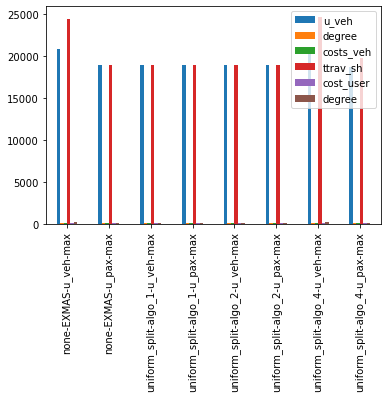

In [124]:
df[df.min_max=='max'].plot.bar()

In [148]:
ret_veh = dict()
for col in inData.sblts.results_rides.columns:
    if '-' in col:
        ret_veh[col] = inData.sblts.results_rides[inData.sblts.results_rides[col]==True][['u_veh','costs_veh']].sum()
df = pd.DataFrame(ret_veh).T
df['min_max'] = df.apply(lambda x: 'min' if 'min' in x.name else 'max', axis=1)
df['obj'] = df.apply(lambda x: 'u_pax' if 'u_pax' in x.name else 'u_veh', axis=1)
df['u_veh'] = df['u_veh']/df.mean()['u_veh']
df['costs_veh'] = df['costs_veh']/df.mean()['costs_veh']
ret= dict()
for col in inData.sblts.results_rm.columns:
    if '-' in col:
        ret[col] = inData.sblts.results_rm[inData.sblts.results_rm[col]==1][['ttrav_sh','cost_user','degree']].sum()
        
df2 = pd.DataFrame(ret).T
#df2['min_max'] = df.apply(lambda x: 'min' if 'min' in x.name else 'max', axis=1)
df2['ttrav_sh'] = df2['ttrav_sh']/df2.mean()['ttrav_sh']
df2['cost_user'] = df2['cost_user']/df2.mean()['cost_user']
df2['degree'] = df2['degree']/100
df = pd.concat([df,df2],axis = 1)

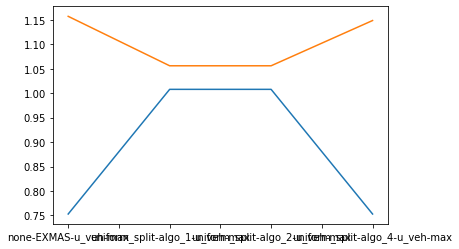

In [151]:
df[(df.min_max=='min') & (df.obj == 'u_veh')].u_veh.plot()
df[(df.min_max=='max') & (df.obj == 'u_veh')].u_veh.plot()

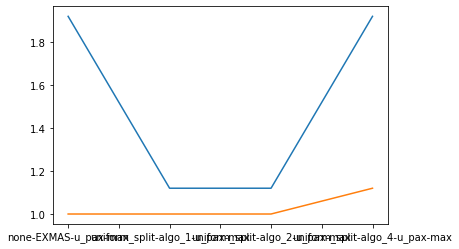

In [154]:
df[(df.min_max=='min') & (df.obj == 'u_pax')].degree.plot()
df[(df.min_max=='max') & (df.obj == 'u_pax')].degree.plot()

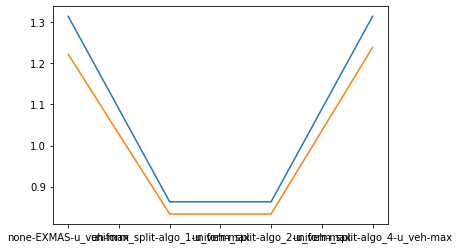

In [155]:
df[(df.min_max=='min') & (df.obj == 'u_veh')].cost_user.plot()
df[(df.min_max=='max') & (df.obj == 'u_veh')].cost_user.plot()

In [145]:
df

,u_veh,costs_veh,min_max,ttrav_sh,cost_user,degree
none-EXMAS-u_veh-min,0.752731,0.752731,min,1.163698,1.314274,2.26
none-EXMAS-u_veh-max,1.157546,1.157546,max,1.157347,1.222081,1.68
none-EXMAS-u_pax-min,0.913564,0.913564,min,1.128624,1.191039,1.92
none-EXMAS-u_pax-max,1.056286,1.056286,max,0.898368,0.833693,1.00
uniform_split-algo_1-u_veh-min,1.008025,1.008025,min,0.914341,0.863427,1.12
uniform_split-algo_1-u_veh-max,1.056286,1.056286,max,0.898368,0.833693,1.00
uniform_split-algo_1-u_pax-min,1.010087,1.010087,min,0.914483,0.859138,1.12
uniform_split-algo_1-u_pax-max,1.056286,1.056286,max,0.898368,0.833693,1.00
uniform_split-algo_2-u_veh-min,1.008025,1.008025,min,0.914341,0.863427,1.12
uniform_split-algo_2-u_veh-max,1.056286,1.056286,max,0.898368,0.833693,1.00


In [43]:
inData.sblts.results_rm

ride  traveller  shared  degree  treq ride_time  dist  ttrav  \
0    0      0          0   False       1     0       125  1002    125   
1    1      1          1   False       1     2       316  2528    316   
2    2      2          2   False       1     4       289  2318    289   
3    3      3          3   False       1     9        44   357     44   
4    4      4          4   False       1    11       167  1343    167   
...       ...        ...     ...     ...   ...       ...   ...    ...   
1522 25  1522         25    True       5    42       525  2825    353   
     70  1522         70    True       5   105       525  2534    316   
     13  1522         13    True       5    24       525  1624    203   
     95  1522         95    True       5   166       525  1682    210   
     77  1522         77    True       5   126       525  1882    235   

         ttrav_sh  delay distance cost_veh  cost_user  cost_single  \
0    0        125    0.0     1000  0.56875    0.43750       0.4375   
1    1        316    0.0     2528   1.4378    1.10600       1.1060   
2    2        289    0.0     2312  1.31495    1.01150       1.0115   
3    3         44    0.0      352   0.2002    0.15400       0.1540   
4    4        167    0.0     1336  0.75985    0.58450       0.5845   
...           ...    ...      ...      ...        ...          ...   
1522 25       500    7.0     4200  2.38875    1.78675       1.2355   
     70       436    8.0     4200  2.38875    1.56800       1.1060   
     13       337  135.0     4200  2.38875    1.88825       0.7105   
     95       387   21.0     4200  2.38875    1.46475       0.7350   
     77       319  129.0     4200  2.38875    1.79375       0.8225   

         uniform_split-EXMAS-u_veh-min  uniform_split-EXMAS-u_veh-max  \
0    0                               1                              0   
1    1                               0                              0   
2    2                               0                              1   
3    3                               1                              1   
4    4                               0                              1   
...                                ...                            ...   
1522 25                              0                              0   
     70                              0                              0   
     13                              0                              0   
     95                              0                              0   
     77                              0                              0   

         uniform_split-EXMAS-u_pax-min  uniform_split-EXMAS-u_pax-max  \
0    0                               0                              1   
1    1                               0                              1   
2    2                               0                              1   
3    3                               1                              1   
4    4                               0                              1   
...                                ...                            ...   
1522 25                              0                              0   
     70                              0                              0   
     13                              0                              0   
     95                              0                              0   
     77                              0                              0   

         uniform_split-algo_1-u_veh-min  uniform_split-algo_1-u_veh-max  \
0    0                                1                               1   
1    1                                0                               1   
2    2                                0                               1   
3    3                                1                               1   
4    4                                1                               1   
...                                 ...                             ...   
1522 25     

In [25]:
inData.sblts.rides_multi_index.join(inData.sblts.rides.selected, on = 'ride')

ride  traveller  shared  degree  treq ride_time  dist  ttrav  \
0    0      0          0   False       1     0       414  3318    414   
1    1      1          1   False       1     1       154  1237    154   
2    2      2          2   False       1     1       211  1689    211   
3    3      3          3   False       1     2       321  2569    321   
4    4      4          4   False       1     3       331  2654    331   
...       ...        ...     ...     ...   ...       ...   ...    ...   
1321 0   1321          0    True       5     0       602  3318    414   
     51  1321         51    True       5    90       602  2605    325   
     46  1321         46    True       5    84       602  1432    179   
     85  1321         85    True       5   146       602  2431    303   
     59  1321         59    True       5   105       602  2227    278   

         ttrav_sh  delay distance cost_veh  cost_user  cost_single  \
0    0        414    0.0     3312   1.8837   1.449000       1.4490   
1    1        154    0.0     1232   0.7007   0.539000       0.5390   
2    2        211    0.0     1688  0.96005   0.738500       0.7385   
3    3        321    0.0     2568  1.46055   1.123500       1.1235   
4    4        331    0.0     2648  1.50605   1.158500       1.1585   
...           ...    ...      ...      ...        ...          ...   
1321 0        602   37.5     4816   2.7391   2.303875       1.4490   
     51       435  -22.5     4816   2.7391   1.640625       1.1375   
     46       370   48.5     4816   2.7391   1.549625       0.6265   
     85       485    8.5     4816   2.7391   1.742125       1.0605   
     59       454   80.5     4816   2.7391   2.011625       0.9730   

         uniform_split  price_single   surplus  pruned_user  pruned  deded  
0    0        3.332700       3.33270  0.000000         True    True      1  
1    1        1.239700       1.23970  0.000000         True    True      1  
2    2        1.698550       1.69855  0.000000         True    True      1  
3    3        2.584050       2.58405  0.000000         True    True      1  
4    4        2.664550       2.66455  0.000000         True    True      1  
...                ...           ...       ...          ...     ...    ...  
1321 0        2.397395       3.33270  0.935305         True   False      0  
     51       2.397395       2.61625  0.218855         True   False      0  
     46       2.397395       1.44095 -0.956445        False   False      0  
     85       2.397395       2.43915  0.041755         True   False      0  
     59       2.397395       2.23790 -0.159495        False   False      0  

[3409 rows x 20 columns]

In [19]:
inData = pricings.update_costs(inData, params)
rm = inData.sblts.rides_multi_index

In [21]:
rm['uniform_split'] = pricings.uniform_split(rm)

In [22]:
inData = prunings.algo_1(inData)

pruned_user  pruned
False        False     AxesSubplot(0.125,0.125;0.775x0.755)
True         False     AxesSubplot(0.125,0.125;0.775x0.755)
             True      AxesSubplot(0.125,0.125;0.775x0.755)
Name: surplus, dtype: object

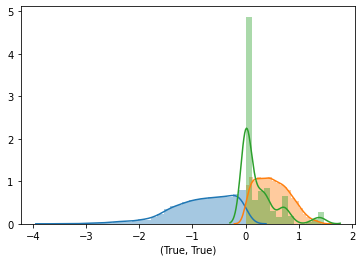

In [114]:
rm.groupby(['pruned_user','pruned']).surplus.apply(sns.distplot, norm_hist = True)

In [150]:
rides['indexes_set']=rides.indexes.apply(set)

0                            {0}
1                            {1}
2                            {2}
3                            {3}
4                            {4}
                  ...           
1821     {32, 37, 8, 48, 89, 57}
1822    {32, 37, 48, 49, 89, 57}
1823     {32, 37, 8, 48, 89, 57}
1824     {32, 37, 8, 48, 49, 89}
1825    {32, 37, 48, 49, 89, 57}
Name: indexes, Length: 1826, dtype: object

In [167]:
rides.loc[1825].subgroups

array([  32,   37,   48,   49,   57,   89,  134,  138,  178,  179,  188,
        190,  302,  352,  355,  356,  359,  428,  431,  432,  434,  447,
        448,  450,  452,  453,  614,  618,  723,  728,  731,  732,  733,
        738,  740,  741,  754,  759,  762,  763,  775,  776,  778,  779,
        869,  870,  979,  980,  988,  989,  993,  994,  995, 1086, 1091,
       1094, 1095, 1096, 1101, 1103, 1104, 1108, 1109, 1130, 1135, 1138,
       1139, 1151, 1152, 1154, 1155, 1160, 1161, 1329, 1430, 1432, 1433,
       1455, 1456, 1459, 1460, 1464, 1466, 1467, 1476, 1477, 1485, 1487,
       1488, 1506, 1507, 1517, 1519, 1520, 1525, 1526, 1535, 1578, 1580,
       1581, 1597, 1598, 1600, 1601, 1605, 1607, 1608, 1619, 1620, 1623,
       1624, 1631, 1633, 1634, 1653, 1654, 1669, 1671, 1672, 1679, 1680,
       1681, 1742, 1743, 1746, 1747, 1755, 1756, 1765, 1766, 1767, 1779,
       1780, 1787, 1788, 1793, 1803, 1804, 1805, 1806, 1813, 1814, 1818,
       1822, 1825])

In [149]:
r = inData.sblts.rides.iloc[-3]
rides[rides.indexes.apply(lambda x: set(r.indexes).issubset(set(x)))].index

def givemesubsets(row):
    return rides[rides.indexes.apply(lambda x: set(x).issubset(set(row.indexes)))].index.values
rides['subgroups'] = rides.apply(givemesubsets, axis = 1)

In [180]:
price_column ='uniform_split'
G = 1825
H = 1460
df = rm.loc[H,:][[price_column]].join(rm.loc[G,:][[price_column]], lsuffix='_G',rsuffix='_H')
df['surplus'] = df.iloc[:,0]-df.iloc[:,1]
return df.surplus.max()>0

,uniform_split_G,uniform_split_H,surplus
32,3.10765,2.794692,0.312958
48,3.10765,2.794692,0.312958
57,3.10765,2.794692,0.312958
89,3.10765,2.794692,0.312958


In [195]:
rm = inData.sblts.rides_multi_index
rides = inData.sblts.rides

def hermetic(ride):
    G = ride.name  
    prices_G = rm.loc[G,:][[price_column]]
    hermetic = True
    for H in ride.subgroups:       
        # determine whether there exists at least one traveller who wants to use G rather than H
        df = rm.loc[H,:][[price_column]].join(prices_G, lsuffix='_H',rsuffix='_G')
        df['surplus'] = df.iloc[:,0]-df.iloc[:,1]
        if df.surplus.max()<0:
            hermetic = False   
            break
    return hermetic

rides['hermetic'] = rides.apply(hermetic,axis = 1)   

In [198]:
rides.groupby('hermetic').size()

hermetic
False    1712
True      114
dtype: int64

In [ ]:
def group_domimancy(rm, G,H):
    # determine whether there exists at least one traveller who wants to use G rather than H
    df = rm.loc[H,:][[price_column]].join(rm.loc[G,:][[price_column]], lsuffix='_G',rsuffix='_H')
    df['surplus'] = df.iloc[:,0]-df.iloc[:,1]
    return df.surplus.max()>0


In [163]:
r = rides.loc[1562]
r[['indexes','subgroups']]
rides.loc[r.subgroups[13]].indexes, r.indexes

([31, 2, 53], [31, 2, 53, 44])

In [133]:
rides = inData.sblts.rides
other_indexes = rides.indexes.copy()
for i, ride in rides.iterrows():
    indexes = ride.indexes
    

In [106]:
rm.tail(10)

ride  traveller  shared  degree  treq ride_time  dist  ttrav  \
1824 37  1824         37    True       6    66       718  2181    272   
     89  1824         89    True       6   147       718  2304    288   
     8   1824          8    True       6    11       718  3505    438   
     49  1824         49    True       6    81       718  1812    226   
1825 32  1825         32    True       6    52       718  3427    428   
     48  1825         48    True       6    80       718  3438    429   
     37  1825         37    True       6    66       718  2181    272   
     89  1825         89    True       6   147       718  2304    288   
     57  1825         57    True       6    98       718  3027    378   
     49  1825         49    True       6    81       718  1812    226   

         ttrav_sh  delay distance cost_veh  cost_user  price_single  \
1824 37       436   48.5     5744   3.7695     1.8655       2.38000   
     89       489   29.5     5744   3.7695     1.9180       2.52000   
     8        543  226.5     5744   3.7695     3.4860       3.83250   
     49       462  237.5     5744   3.7695     3.2795       1.97750   
1825 32       611   10.5     5744   3.7695     2.2120       3.74500   
     48       589    4.5     5744   3.7695     2.0930       3.75375   
     37       444   48.5     5744   3.7695     1.8935       2.38000   
     89       497   29.5     5744   3.7695     1.9460       2.52000   
     57       538  144.5     5744   3.7695     2.8945       3.30750   
     49       454  245.5     5744   3.7695     3.3075       1.97750   

         uniform_split  pruned_user  pruned   surplus  
1824 37       3.094583        False   False -0.714583  
     89       3.094583        False   False -0.574583  
     8        3.094583         True   False  0.737917  
     49       3.094583        False   False -1.117083  
1825 32       3.019333         True   False  0.725667  
     48       3.019333         True   False  0.734417  
     37       3.019333        False   False -0.639333  
     89       3.019333        False   False -0.499333  
     57       3.019333         True   False  0.288167  
     49       3.019333        False   False -1.041833

In [82]:
rm.tail(10)

ride  traveller  shared  degree  treq ride_time  dist  ttrav  \
1824 37  1824         37    True       6    66       718  2181    272   
     89  1824         89    True       6   147       718  2304    288   
     8   1824          8    True       6    11       718  3505    438   
     49  1824         49    True       6    81       718  1812    226   
1825 32  1825         32    True       6    52       718  3427    428   
     48  1825         48    True       6    80       718  3438    429   
     37  1825         37    True       6    66       718  2181    272   
     89  1825         89    True       6   147       718  2304    288   
     57  1825         57    True       6    98       718  3027    378   
     49  1825         49    True       6    81       718  1812    226   

         ttrav_sh  delay distance cost_veh  cost_user  costs_user  costs_veh  \
1824 37       436   48.5     5744   30.156     1.8655         NaN        NaN   
     89       489   29.5     5744   30.156     1.9180         NaN        NaN   
     8        543  226.5     5744   30.156     3.4860         NaN        NaN   
     49       462  237.5     5744   30.156     3.2795         NaN        NaN   
1825 32       611   10.5     5744   30.156     2.2120         NaN        NaN   
     48       589    4.5     5744   30.156     2.0930         NaN        NaN   
     37       444   48.5     5744   30.156     1.8935         NaN        NaN   
     89       497   29.5     5744   30.156     1.9460         NaN        NaN   
     57       538  144.5     5744   30.156     2.8945         NaN        NaN   
     49       454  245.5     5744   30.156     3.3075         NaN        NaN   

         price_single  
1824 37        0.9520  
     89        1.0080  
     8         1.5330  
     49        0.7910  
1825 32        1.4980  
     48        1.5015  
     37        0.9520  
     89        1.0080  
     57        1.3230  
     49        0.7910

In [316]:
pruned = rides.groupby('ride')['pruned_user'].min().to_frame('pruned')
pruned['ride'] = pruned.index
rides['pruned'] = rides.join(pruned['pruned'], on = 'ride')
rides.groupby('ride')

,ride
ride,
0,True
1,True
2,True
3,True
4,True
5,True
6,True
7,True
8,True


In [62]:
def calc_delay(r):
    deps = [r.times[0]]
    for d in r.times[1:r.degree]:
        deps.append(deps[-1]+d) # departure times
    t = inData.sblts.requests
    return deps
inData.sblts.rides.apply(calc_delay, axis = 1)
inData.sblts.rides[]

0                        [0]
1                        [1]
2                        [2]
3                       [28]
4                       [42]
5                       [52]
6                       [69]
7                       [83]
8                      [155]
9                      [163]
10             [-21.0, 88.0]
11               [6.5, 91.5]
12            [-96.0, 112.0]
13              [-3.5, 88.5]
14           [-165.5, 345.5]
15              [15.5, 43.5]
16            [-34.0, 102.0]
17            [-17.5, 153.5]
18              [-3.5, 88.5]
19             [43.0, 107.0]
20             [11.5, 167.5]
21              [7.0, 240.0]
22               [6.5, 91.5]
23              [9.5, 161.5]
24           [-130.0, 147.0]
25           [-144.5, 189.5]
26              [15.5, 43.5]
27           [-113.0, 182.0]
28            [-85.5, 185.5]
29             [43.0, 107.0]
30             [75.0, 164.0]
31      [-21.0, 88.0, 152.0]
32     [-34.0, 102.0, 194.0]
33        [6.5, 91.5, 155.5]
34    [-130.0,

In [68]:
R = inData.sblts.rides
r = R.sample(1).squeeze()
r.treqs - r.deps, r.deps, r.treqs

(array([-6.5, -8.5]), [6.5, 91.5], array([ 0, 83]))

In [43]:
t = inData.sblts.requests
treqs = list(t.loc[r.indexes_orig].treq.values)
deps[:len(r.indexes_dest)], treqs
[treq-deps[i] for i,treq in enumerate(treqs)]

[69.5, -84.5]

In [6]:
inData.sblts.requests

,index,origin,destination,treq,tdep,ttrav,tarr,tdrop,dist,pax_id,VoT,delta,u,u_PT,ride_id,ttrav_sh,u_sh,kind,position
0,5,1658828034,44996090,0,NaN,164,2020-09-25 17:20:42,NaN,1317,5,0.0035,179.241758,2.5495,999999,11,198,1.918225,20,0
1,6,44989210,1658828038,1,NaN,206,2020-09-25 17:26:15,NaN,1649,6,0.0035,224.274725,3.1945,999999,20,209,2.945275,20,1
2,9,45021401,2502729245,2,NaN,501,2020-09-25 18:05:35,NaN,4008,9,0.0035,545.043956,7.7655,999999,26,580,5.774675,21,0
3,1,45024107,2502710368,28,NaN,141,2020-09-25 17:18:08,NaN,1135,1,0.0035,154.549451,2.1960,999999,3,141,2.196000,1,0
4,4,45024108,510614415,42,NaN,236,2020-09-25 17:30:57,NaN,1890,4,0.0035,257.076923,3.6610,999999,26,236,2.552725,21,1
5,2,5040974850,4818737407,52,NaN,156,2020-09-25 17:20:28,NaN,1251,2,0.0035,170.208791,2.4225,999999,17,171,2.032525,20,0
6,7,4818737407,44993506,69,NaN,232,2020-09-25 17:30:54,NaN,1860,7,0.0035,253.054945,3.6020,999999,17,232,2.835075,20,1
7,8,45003346,44994279,83,NaN,123,2020-09-25 17:16:33,NaN,985,8,0.0035,133.978022,1.9080,999999,11,160,1.564575,20,1
8,10,45023679,45022840,155,NaN,96,2020-09-25 17:14:09,NaN,769,10,0.0035,104.604396,1.4895,999999,8,96,1.489500,1,0
9,3,2502729230,1665808438,163,NaN,260,2020-09-25 17:36:08,NaN,2080,3,0.0035,282.857143,4.0300,999999,20,274,3.496025,20,0


### incidence matrix
rows are trips columns are rides,
1 if trip blongs to a ride, 0 otherwise

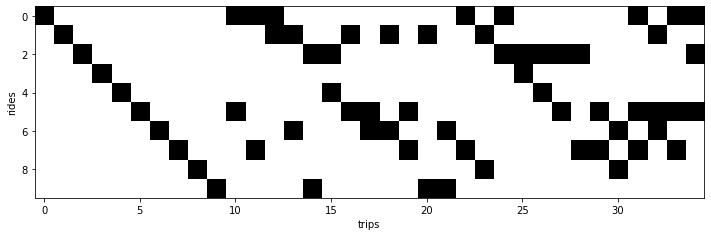

In [7]:
mtx = np.vstack(inData.sblts.rides['row'].values).T  # creates a numpy array for the constrains
m = pd.DataFrame(mtx).astype(int)
plt.rcParams['figure.figsize'] = [12, int(12*inData.sblts.rides.shape[0]/inData.requests.shape[0])]
fig, ax = plt.subplots()
ax.imshow(m, cmap='Greys', interpolation = 'Nearest')
ax.set_ylabel('rides')
_ = ax.set_xlabel('trips')
m.index.name = 'trips'
m.columns.name = 'rides'
inData.sblts.m = m

In [8]:
ret = dict()
sums = mtx.sum(axis=0)
for i in range(mtx.shape[1]): # chech this ride
    ret[i] = list()
    for j in range(mtx.shape[1]): # if other rides are contained with it
        if j != i: # if they are different
            if sums[j]<sums[i]: # and of lower degree               
                if sum(mtx[:,j]*mtx[:,i]) == sums[j]: # and the contiaining ride j contains all travellers of contained ride i
                    ret[i].append(j) # append for a dict 
inData.sblts.rides['subrides'] = pd.Series(ret)

### costs for system optima (column sums)
* passengers ('u_pax')
* vehicle ('u_veh')

In [8]:
inData.sblts.rides[['u_pax','u_veh']].T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
u_pax,2.5495,3.1945,7.7655,2.196,3.661,2.4225,3.602,1.908,1.4895,4.03,3.96895,3.4828,5.0728,5.90775,10.1716,8.4184,5.4419,4.8676,6.15345,3.5607,6.4413,7.40035,3.5556,4.1613,8.98965,9.1307,8.3274,8.83095,7.7169,3.4879,4.10115,6.3912,8.3657,6.47993,11.9026
u_veh,164,206,501,141,236,156,232,123,96,260,317,260,416,470,858,592,469,418,432,234,380,512,266,403,670,725,595,688,575,257,360,388,591,395,801


### costs for single passengers

In [9]:
m_user_costs = m.copy()
for col in m.columns:
    new_col = [0]*params.nP
    indexes = inData.sblts.rides.loc[col]['indexes']
    u_paxes = inData.sblts.rides.loc[col].u_paxes
    for l,i in enumerate(indexes):
        new_col[i] = u_paxes[l]
    m_user_costs[col] = new_col
m_user_costs = m_user_costs.round(1)
m_user_costs

rides,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
trips,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.9,2.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.2,0.0,2.3,0.0,0.0,0.0,0.0,0.0,0.0,2.4,0.0,2.4,2.4
1,0.0,3.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.7,2.8,0.0,0.0,3.1,0.0,3.1,0.0,2.9,0.0,0.0,3.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.8,0.0,0.0
2,0.0,0.0,7.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.3,5.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.7,7.0,5.8,6.7,6.0,0.0,0.0,0.0,0.0,0.0,7.2
3,0.0,0.0,0.0,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,3.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.4,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.3,2.0,0.0,1.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.2,0.0,2.1,0.0,2.4,2.3,2.3,2.3
6,0.0,0.0,0.0,0.0,0.0,0.0,3.6,0.0,0.0,0.0,0.0,0.0,0.0,3.1,0.0,0.0,0.0,2.8,3.0,0.0,0.0,3.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.1,0.0,3.3,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.9,0.0,0.0,0.0,1.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.7,0.0,0.0,1.3,0.0,0.0,0.0,0.0,0.0,1.7,1.3,0.0,1.7,0.0,1.8,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### ranking

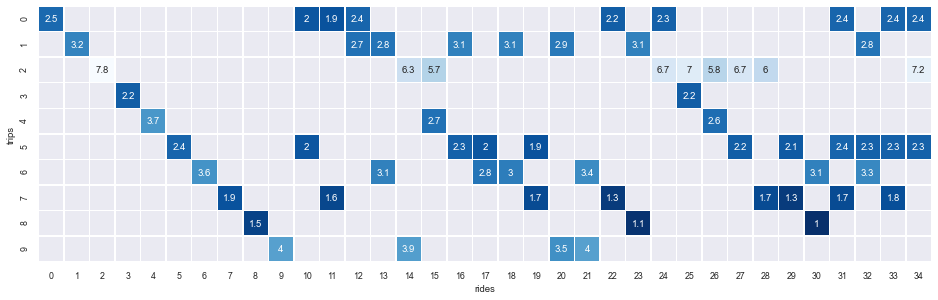

In [10]:
m_user_costs = m_user_costs.replace(0, np.nan)
sns.set(font_scale=0.8)
fig, ax = plt.subplots(figsize = (16,16))
_ = sns.heatmap(m_user_costs, annot=True, mask = m_user_costs == np.nan , cbar = False, ax = ax, square = True, cmap = 'Blues_r', linewidths=.5)

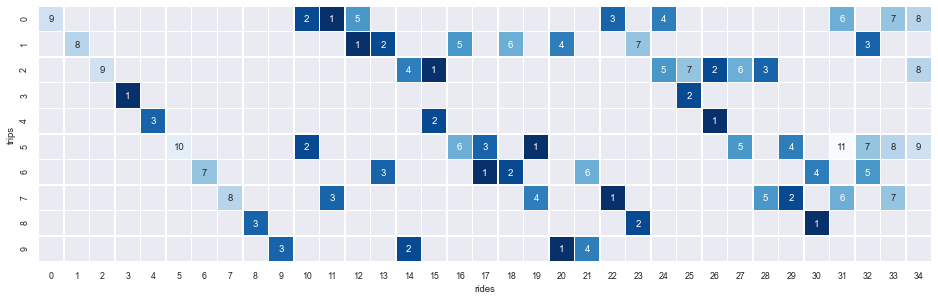

In [11]:
ranking = m_user_costs.replace(0, np.nan).rank(1, ascending = True, method = 'first')
sns.set(font_scale=0.8)
fig, ax = plt.subplots(figsize = (16,16))
_ = sns.heatmap(ranking, annot=True, mask = m_user_costs == np.nan , cbar = False, ax = ax, square = True, cmap = 'Blues_r', linewidths=.5)

### probabilities

apply simple logit model with high $\beta$  

<AxesSubplot:xlabel='rides', ylabel='trips'>

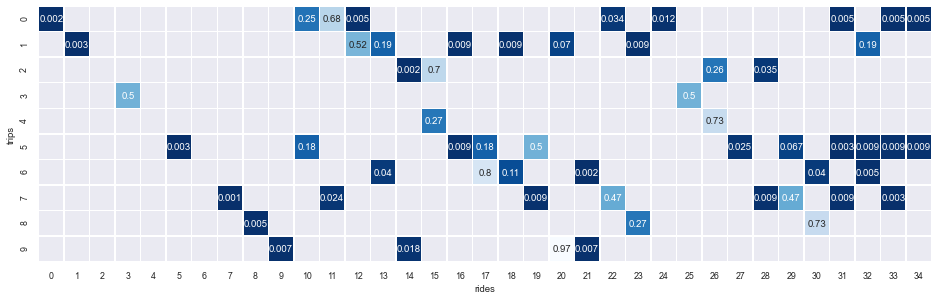

In [12]:
beta = -10 # behavioural parameter

probs = m_user_costs.replace(0,np.inf) # set rides without this pax to inf
probs = probs.applymap(lambda x: math.exp(beta*x))  # calculate exp to MNL
probs = probs.div(probs.sum(axis=1), axis =0).round(3) # divide by sum of utilities
fig, ax = plt.subplots(figsize = (16,16))
sns.heatmap(probs, annot=True, mask = probs == 0 , cbar = False, ax = ax, square = True, cmap = 'Blues_r', linewidths=.5)

---
# PoA in ILP
---

compute PoA

In [18]:
def calc_solution_PoA(inData):
    indexes = dict()
    utilities = dict()
    for _ in inData.sblts.requests.index:
        indexes[_] = list()
        utilities[_] = list()
    for i,row in inData.sblts.rides.iterrows():
        for j,traveller in enumerate(row.indexes):
            indexes[traveller] += [i]
            utilities[traveller] += [row.u_paxes[j]]

    inData.sblts.requests['ride_indexes'] = pd.Series(indexes)
    inData.sblts.requests['ride_utilities'] = pd.Series(utilities)
    inData.sblts.requests['min_utility'] = inData.sblts.requests['ride_utilities'].apply(lambda x: min(x))
    inData.sblts.requests['PoA'] = inData.sblts.requests['u_sh'] - inData.sblts.requests['min_utility']
    inData.sblts.requests['PoA_relative'] = (inData.sblts.requests['u_sh'] - inData.sblts.requests['min_utility'])/inData.sblts.requests['min_utility']
    #inData.sblts.requests['ranking'] = inData.sblts.requests.apply(lambda x: int(ranking.loc[x.name][x.ride_id]),axis =1)
    return inData


In [19]:
inData.sblts.rides['degree'] = inData.sblts.rides.apply(lambda x: len(x.indexes),axis = 1)
inData.sblts.rides['rankings'] = inData.sblts.rides.apply(lambda ride: [int(ranking.loc[traveller][ride.name]) for traveller in ride.indexes],axis = 1)
inData.sblts.rides['mean_ranking'] = inData.sblts.rides.apply(lambda ride: sum(ride.rankings) / ride.degree,axis = 1)
rel_ranking = ranking.div(ranking.max(axis=1),axis = 0)
inData.sblts.rides['rel_rankings'] = inData.sblts.rides.apply(lambda ride: [rel_ranking.loc[traveller][ride.name] for traveller in ride.indexes],axis = 1)
inData.sblts.rides['mean_rel_ranking'] = inData.sblts.rides.apply(lambda ride: sum(ride.rel_rankings) / ride.degree,axis = 1)
inData.sblts.rides['PoA'] = inData.sblts.rides.apply(lambda ride: [m_user_costs.loc[traveller][ride.name]-m_user_costs.loc[traveller].min() for traveller in ride.indexes],axis = 1)
inData.sblts.rides['mean_PoA'] = inData.sblts.rides.apply(lambda ride: sum(ride.PoA) / ride.degree,axis = 1)
inData.sblts.rides['total_PoA'] = inData.sblts.rides.apply(lambda ride: sum(ride.PoA) / ride.degree,axis = 1)

pricing in the group

In [28]:
df = inData.sblts.schedule.loc[26:26][['indexes','u_pax','u_paxes','u_veh','PassHourTrav_ns']]
df.index.name = 'group id'
df.columns = ['travellers','disutilities, total', 'disutilities, per traveller', 'total travel time shared', 'total travel time non shared']
df

,travellers,"disutilities, total","disutilities, per traveller",total travel time shared,total travel time non shared
group id,,,,,
26,"[2, 4]",8.3274,"[5.774675, 2.552725]",595,737


In [24]:
df = inData.sblts.requests.loc[[2,4]][['u_sh','u','ttrav_sh','ttrav']]
df.columns = [['disutility in the shared ride', 'disutility in the non-shared ride', 'travel time shared','travel time non_shared']]
df.index.name = 'traveller'
df

,disutility in the shared ride,disutility in the non-shared ride,travel time shared,travel time non_shared
traveller,,,,
2,5.774675,7.7655,580,501
4,2.552725,3.6610,236,236


### Solution: system optimal for user costs ('u_pax')

In [31]:
def test_obj_fun(inData, obj = 'u_pax', _plot = True):
    params.matching_obj = obj
    inData = matching(inData, params, plot = False)
    if _plot:
        m_solution = inData.sblts.m.copy()
        fig, ax = plt.subplots()
        for col in m_solution.columns:
            if inData.sblts.rides.loc[col].selected==0:
                m_solution[col] = m[col]
            else:
                m_solution[col] = m[col]*5

        ax.imshow(m_solution, cmap='Greys', interpolation = 'Nearest')
        ax.set_ylabel('rides')
        _ = ax.set_xlabel('trips')
        print('grey - feasible, black - selected')
    inData = calc_solution_PoA(inData)
    return inData.sblts.requests.PoA.sum()
ret=dict()
for obj in ['u_pax', 'u_veh','total_PoA', 'mean_PoA', 'mean_rel_ranking']:
    ret[obj]=test_obj_fun(inData, obj = obj, _plot = False)
pd.Series(ret,name='PoA').to_frame()

,PoA
u_pax,1.190525
u_veh,2.924325
total_PoA,2.022700
mean_PoA,2.022700
mean_rel_ranking,1.931700


grey - feasible, black - selected


(1.190525000000001, 0.8057705796471463)

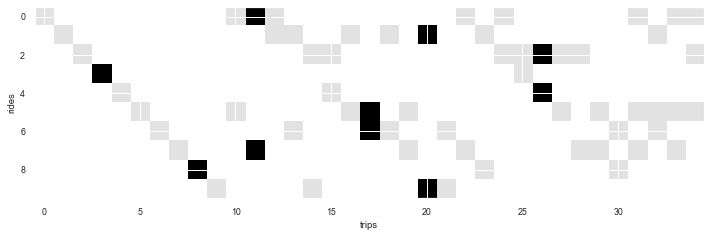

### Solution: system optimal for operator costs ('u_veh')

grey - feasible, black - selected


(2.9243250000000005, 1.6101323015426394)

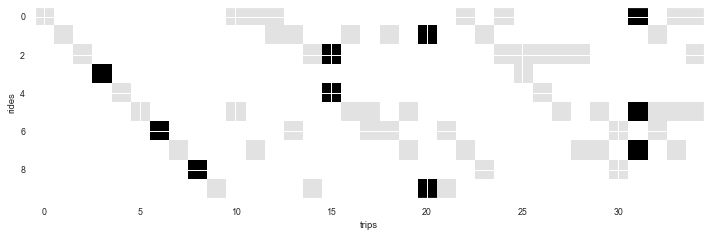

In [16]:
params.matching_obj = 'u_veh'
inData = matching(inData, params, plot = False)
m_solution = m.copy()
fig, ax = plt.subplots()
for col in m.columns:
    if inData.sblts.rides.loc[col].selected==0:
        m_solution[col] = m[col]
    else:
        m_solution[col] = m[col]*5
ax.imshow(m_solution, cmap='Greys', interpolation = 'Nearest')
ax.set_ylabel('rides')
_ = ax.set_xlabel('trips')
print('grey - feasible, black - selected')
inData = calc_solution_PoA(inData)
inData.sblts.requests.PoA.sum(), inData.sblts.requests.PoA_relative.sum()

grey - feasible, black - selected


(2.0227, 1.0596280933754736)

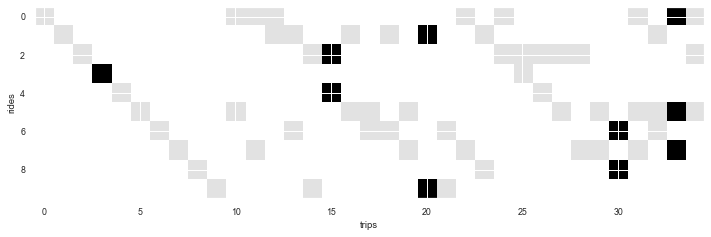

In [17]:
params.matching_obj = 'total_PoA'
inData = matching(inData, params, plot = False)
m_solution = m.copy()
fig, ax = plt.subplots()
for col in m.columns:
    if inData.sblts.rides.loc[col].selected==0:
        m_solution[col] = m[col]
    else:
        m_solution[col] = m[col]*5
ax.imshow(m_solution, cmap='Greys', interpolation = 'Nearest')
ax.set_ylabel('rides')
_ = ax.set_xlabel('trips')
print('grey - feasible, black - selected')
inData = calc_solution_PoA(inData)
inData.sblts.requests.PoA.sum(), inData.sblts.requests.PoA_relative.sum()

grey - feasible, black - selected


(2.0227, 1.0596280933754736)

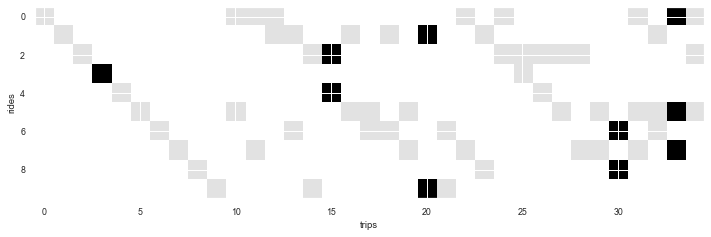

In [18]:
params.matching_obj = 'mean_PoA'
inData = matching(inData, params, plot = False)
m_solution = m.copy()
fig, ax = plt.subplots()
for col in m.columns:
    if inData.sblts.rides.loc[col].selected==0:
        m_solution[col] = m[col]
    else:
        m_solution[col] = m[col]*5
ax.imshow(m_solution, cmap='Greys', interpolation = 'Nearest')
ax.set_ylabel('rides')
_ = ax.set_xlabel('trips')
print('grey - feasible, black - selected')
inData = calc_solution_PoA(inData)
inData.sblts.requests.PoA.sum(), inData.sblts.requests.PoA_relative.sum()

grey - feasible, black - selected


(1.931700000000001, 1.0062832083627762)

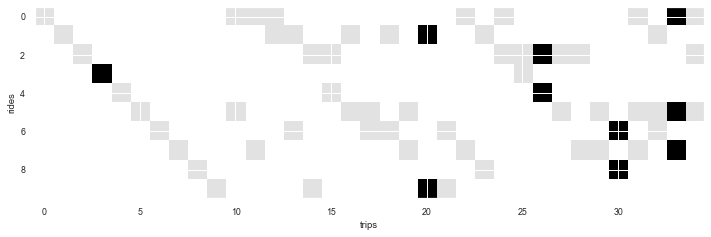

In [19]:
params.matching_obj = 'mean_rel_ranking'
inData = matching(inData, params, plot = False)
m_solution = m.copy()
fig, ax = plt.subplots()
for col in m.columns:
    if inData.sblts.rides.loc[col].selected==0:
        m_solution[col] = m[col]
    else:
        m_solution[col] = m[col]*5
ax.imshow(m_solution, cmap='Greys', interpolation = 'Nearest')
ax.set_ylabel('rides')
_ = ax.set_xlabel('trips')
print('grey - feasible, black - selected')
inData = calc_solution_PoA(inData)
inData.sblts.requests.PoA.sum(), inData.sblts.requests.PoA_relative.sum()

### KPIs for two solutions

In [20]:
KPIs['u_veh'] = inData.sblts.res
KPIs['description']  = ExMAS.utils.KPIs_descriptions
KPIs

,u_pax,u_veh,description
VehHourTrav,1830,1830,total travel time of vehicles (with travellers...
VehHourTrav_ns,2115,2115,as above yet in non-shared scenarion
PassHourTrav,2297,2297,total travel time of passengers
PassHourTrav_ns,2115,2115,as above yet in non-shared scenarion
PassUtility,26.8046,26.8046,total (dis)utility of passengers
PassUtility_ns,32.8185,32.8185,as above yet in non-shared scenarion
mean_lambda,0.119808,0.119808,mean vehicle cost reduction (lambda) over shar...
revenue_s,1586.25,1586.25,total fares paid by travellers sharing
revenue_ns,3172.5,3172.5,as above yet in non-shared scenarion
Fare_Discount,-0.5,-0.5,relative revenue reduction


---
(c) Rafał Kucharski, Delft, 2020